In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

data_raw = pd.read_csv("VCG_Data_Clean.csv", encoding='ISO 8859-1')

data = data_raw[list(data_raw.loc[:,'gender':'race']) + ['religion'] + 
         list(data_raw.loc[:,'biden_vir_humil':'trump_sin_sloth']) + 
         list(data_raw.loc[:,'party':'biden_hill']) + ['shift']]

x = data.copy()

x = x.drop(['trump_why_text','lean','vote_choice','vote_2016'], axis = 1)

xtot = x.dropna(subset=['shift'])

y = xtot['shift']

x = xtot.drop(['shift'], axis=1)

num_col = x.select_dtypes(['number']).columns

imp = SimpleImputer(strategy='mean')
imp.fit(x[num_col])
x[num_col] = imp.transform(x[num_col])

cat_col = x.select_dtypes(['object']).columns

xint = x.copy()

xint[cat_col] = x[cat_col].astype('category')

xint[cat_col] = xint[cat_col].apply(lambda x: x.cat.codes)

# How many shifters?

print(y.value_counts())

# Create train/test splits

x_train, x_test, y_train, y_test = train_test_split(xint, y, test_size = 0.3, random_state = 7)


stay     371
shift     67
Name: shift, dtype: int64


In [2]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB().fit(xint, y)

pred = nb.predict(x_test)
print(np.mean(pred == y_test).round(decimals=2))

scores = cross_val_score(nb, xint, y, cv=10)

print(scores)

scores.mean().round(decimals=2)

0.91
[0.88636364 0.88636364 0.79545455 0.81818182 0.88636364 0.86363636
 0.93181818 0.86363636 1.         0.86046512]


0.88

In [3]:
from sklearn.svm import SVC

svc = SVC(kernel='linear').fit(x_test, y_test)

score_svc = cross_val_score(svc, xint, y, cv=10)
score_svc
score_svc.mean()

0.8608879492600423

In [4]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(svc, random_state=1).fit(x_test, y_test)
eli5.show_weights(perm, feature_names = x_test.columns.tolist(), top=70)


F:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
F:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.1045 ± 0.0061,biden_why_virus
0.0924 ± 0.0422,religion
0.0818 ± 0.0411,trump_sin_envy
0.0561 ± 0.0297,biden_why_foreign
0.0485 ± 0.0182,trump_sin_greed
0.0470 ± 0.0148,biden_why_honest
0.0439 ± 0.0061,biden_vir_diligence
0.0303 ± 0.0254,vote_likely
0.0273 ± 0.0155,biden_vir_chaste
0.0242 ± 0.0223,trump_why_immig


In [5]:
from sklearn.ensemble import RandomForestClassifier

ranfor = RandomForestClassifier().fit(x_test, y_test)

score_ranfor = cross_val_score(ranfor, xint, y, cv=10)
score_ranfor
score_ranfor.mean()

0.9246828752642706

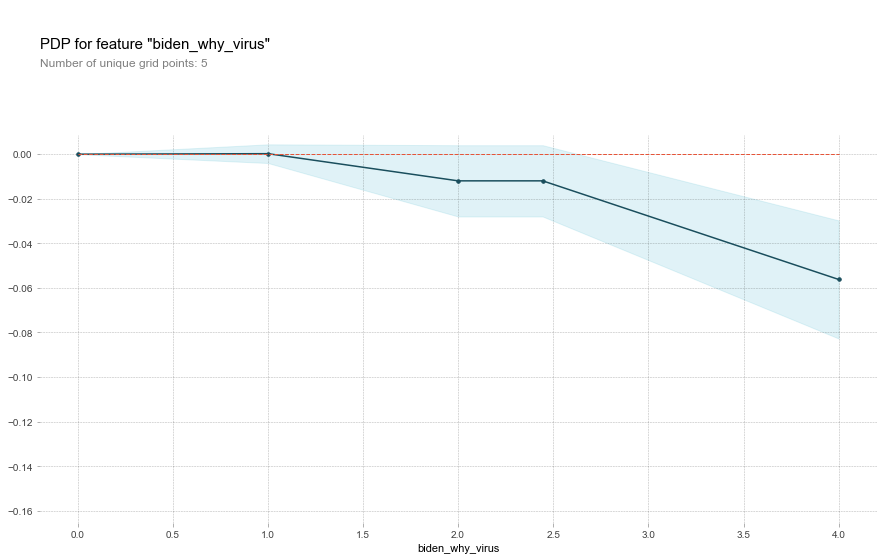

In [6]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

pdp_virus = pdp.pdp_isolate(model=ranfor, dataset=x_test, 
                            model_features = x_test.columns.tolist(),
                           feature='biden_why_virus')

pdp.pdp_plot(pdp_virus, 'biden_why_virus')
plt.show()

In [7]:
import shap

pred_dat = x_test.iloc[7]
explain = shap.TreeExplainer(ranfor)
shap_val = explain.shap_values(pred_dat)
    
shap.initjs()
shap.force_plot(explain.expected_value[1], shap_val[1], pred_dat)

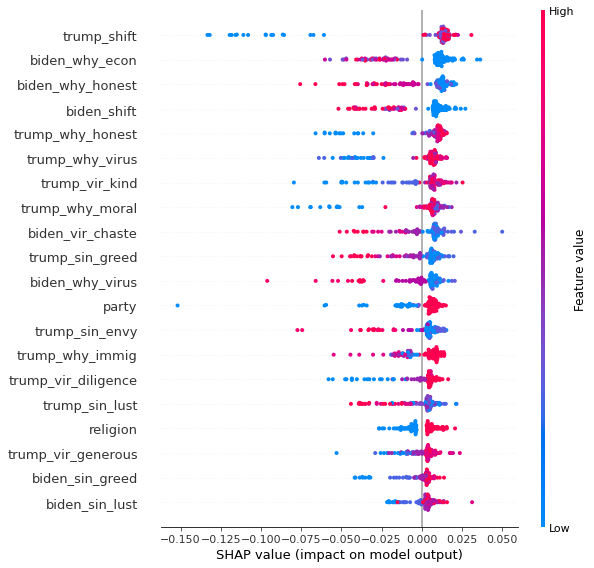

In [8]:
shap_sum = explain.shap_values(x_test)

shap.summary_plot(shap_sum[1], x_test)

In [ ]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, pred))

In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = 2)
gmm.fit(xint)

labels = gmm.predict(xint)
frame = xint.copy()
frame['shift'] = labels

frame.head()